# Import Libraries

In [ ]:
#!pip install --upgrade scipy
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f
from scipy.special import betainc
from scipy.stats import norm, f
from scipy.ndimage import rotate
import re

# Define Parameters

In [2]:
# Define parameters
d = [0.05]#, 0.01, 0.005, 0.001]
f2 = [0.1]#, 0.2, 0.3]
df = [1]#, 2, 3]
Ns = [150]#[50, 100, 150, 200]

In [ ]:
z_score_from_alpha(0.05, tail='right') # assuming 1-tailed test (1.64 at alpha 0.05)

1.644853626951472

# Define Functions

In [25]:
# Function to load NIfTI images
def load_nii(filename):
    return nib.load(filename)

# Function to compute z-score from alpha
def z_score_from_alpha(alpha, tail='two-sided'):
    """
    Calculates the z-score from a given alpha value.

    Parameters:
    alpha (float): Significance level (e.g., 0.05).
    tail (str): Type of test tail ('two-sided', 'left', or 'right').
                  Defaults to 'two-sided'.

    Returns:
    float: Z-score corresponding to the alpha value.
    """
    if tail == 'two-sided':
        z = norm.ppf(1 - alpha/2)
    elif tail == 'left':
        z = norm.ppf(alpha)
    elif tail == 'right':
         z = norm.ppf(1 - alpha)
    else:
        raise ValueError("tail must be 'two-sided', 'left', or 'right'")
    return z


# Function for power calculations
def power_calcs2(df1, df2, cohens_f2, alpha, Contrast_img):

    Fcrit = f.ppf(1 - alpha, df1, df2) # returns the inverse cumulative distribution function of the F distribution with degrees of freedom df1 and df2, evaluated at the probability value of 1 - alpha

    SPM_ZtoP = 2 * (1 - norm.cdf(Contrast_img)) #where SPM_Zobs was hardcoded 1.75 - do we need the absolute value of the zscore?

    lambda_ = (df1 + df2 + 1) * cohens_f2
    kappa = (df1 + lambda_) / df1
    df2_lambda = ((df1 + lambda_) ** 2) / (df1 + 2 * lambda_)

    F_prime = Fcrit / kappa
    x = (df2_lambda * F_prime) / (df2 + df2_lambda * F_prime)
    beta = betainc(df2_lambda / 2, df2 / 2, x)

    power = 1 - beta

    return power, SPM_ZtoP


def calculate_second_gen_p_value(observed_effect, null_hypothesis, effect_interval, n, alpha):
    """
    Calculate second-generation p-value for neuroimaging data
    
    Parameters:
        observed_effect (float): Estimated effect size from neuroimaging analysis - Contrast_img (z scores)
        null_hypothesis (float): Point null hypothesis value #### this should be the mean of the population (which for fmri is 0)
        effect_interval (float): Interval of practically equivalent effects - Contrast_Scaled (cohen's f^2 based on f2 power value)
    
    Returns:
        tuple: (delta_p, interpretation)
    """

    #Calculate standard deviation 
    std = z_score_from_alpha(alpha, tail='right') # assuming 1-tailed test (1.64 at alpha 0.05)
    
    # Standard error calculated from the sample size and standard deviation (from the alpha value)
    std_error = std / np.sqrt(n-1) # n-1 because t-tests
    #print(std_error)
    
    #CI of each voxel
    # Lower and upper bounds of confidence interval
    ci_lower = observed_effect - (observed_effect * std_error) # observed_effect is the z_score?
    #print(ci_lower)
    ci_upper = observed_effect + (observed_effect * std_error)
    #print(ci_upper)
    
    #H0 of overall study
    # Lower and upper bounds of effect interval
    interval_lower = null_hypothesis - effect_interval
    #print(interval_lower)
    interval_upper = null_hypothesis + effect_interval
    #print(interval_upper)
    
    # Calculate second-generation p-value
    if ci_upper <= interval_upper and ci_lower >= interval_lower: #CI entirely contained in the indifference zone (interval)
        # Conclusive evidence against null
        delta_p = 1.0
        #interpretation = 'The data supports the null hypothesis - not scientifically or clinically meaningful'
    elif ci_upper < interval_lower or ci_lower > interval_upper: #absolutely no overlap of CI with the indifference zone 
        # Confidence interval completely covers equivalence interval
        delta_p = 0.0
        #interpretation = 'The data supports an alternative hypothesis that is scientifically OR clinically meaningful'
    elif (ci_upper - ci_lower) > (2*(interval_upper-interval_lower)): 
        # Confidence interval more than twice the length of the null interval (p.4 and top p.6)
        delta_p = 0.5
        #interpretation = 'Data is strictly inconclusive'
    else: 
        # Confidence interval less than twice the length of the null interval (p.4)
        # Partial overlap (either above or below null interval) - ### is there a situation in which it could be both?
        overlap_lower = max(ci_lower, interval_lower)
        overlap_upper = min(ci_upper, interval_upper)
        
        # Calculate proportion of overlap
        delta_p = (overlap_upper - overlap_lower) / (ci_upper - ci_lower)
        #interpretation = 'Partial evidence, some consistency with null' #overlap fraction
         
    return delta_p


# Get Power, P-Val, and 2nd Gen P-Val and Each Voxel (Contrast Images)
### Looped for each f2, sample size (N), and alpha

In [26]:
# Load fMRI images
MNIAtlas = load_nii('anatomical.nii.gz')
Contrast = load_nii('language_uniformity-test_z_FDR_0.01.nii.gz')
#Contrast = load_nii('language_association_test_z_FDR_0.01.nii.gz')

# Extract image data
Contrast_img = Contrast.get_fdata()

# Compute max contrast
MaxContrast = np.max(Contrast_img)

for a in f2:
    # Scale contrast images
    Contrast_Scaled = (a / MaxContrast) * Contrast_img

    # Get image dimensions correctly
    XDIM, YDIM, ZDIM = Contrast_img.shape
    PowerImage = np.zeros((XDIM, YDIM, ZDIM))
    PvalImage = np.zeros((XDIM, YDIM, ZDIM))
    SecGenPvalImage = np.zeros((XDIM, YDIM, ZDIM))

    for n in Ns:
        for alpha in d:
            for i in range(XDIM):
                for j in range(YDIM):
                    for k in range(ZDIM):
                        if Contrast_Scaled[i, j, k] > 0:
                            stat_power, stat_pval = power_calcs2(1, n, Contrast_Scaled[i, j, k], alpha, Contrast_img[i, j, k]) # only calculate power on non-0 values
                            secgenpval = calculate_second_gen_p_value(Contrast_img[i, j, k], 0, Contrast_Scaled[i, j, k], n, alpha)
                            
                            # Power analysis
                            PowerThreshold = 1 - a
                            if stat_power >= PowerThreshold:
                                PowerImage[i, j, k] = stat_power #adjusts 3d matrix on values to only include power values that meet threshold (overwrites default zeros)
                            # Pval analysis
                            if stat_pval <= alpha:
                                PvalImage[i, j, k] = stat_pval 
                            # Second Gen Pval analysis
                            if secgenpval < 0.5:
                                SecGenPvalImage[i, j, k] = secgenpval 

            # Format filename correctly
            pvalue = str(alpha).replace('0.', '')
            f2value = str(a).replace('0.', '0')

            # Save power image as a NIfTI file
            power_filename = f'images/PowerContrast_N{n}_p{pvalue}_Power{int(PowerThreshold * 100)}_f2{f2value}.nii.gz'
            print(power_filename)
            PowerImage_nii = nib.Nifti1Image(PowerImage, Contrast.affine, Contrast.header)
            nib.save(PowerImage_nii, power_filename)

            # Save pval image as a NIfTI file
            pval_filename = f'images/PValContrast_N{n}_p{pvalue}_Power{int(PowerThreshold * 100)}_f2{f2value}.nii.gz'
            print(pval_filename)
            PvalImage_nii = nib.Nifti1Image(PvalImage, Contrast.affine, Contrast.header)
            nib.save(PvalImage_nii, pval_filename)

            # Save second gen pval image as a NIfTI file
            secgenpval_filename = f'images/SecGenPValContrast_N{n}_p{pvalue}_Power{int(PowerThreshold * 100)}_f2{f2value}.nii.gz'
            print(secgenpval_filename)
            SecGenPvalImage_nii = nib.Nifti1Image(SecGenPvalImage, Contrast.affine, Contrast.header)
            nib.save(SecGenPvalImage_nii, secgenpval_filename)


images/PowerContrast_N150_p05_Power90_f201.nii.gz
images/PValContrast_N150_p05_Power90_f201.nii.gz
images/SecGenPValContrast_N150_p05_Power90_f201.nii.gz


# Activation Maps - Power

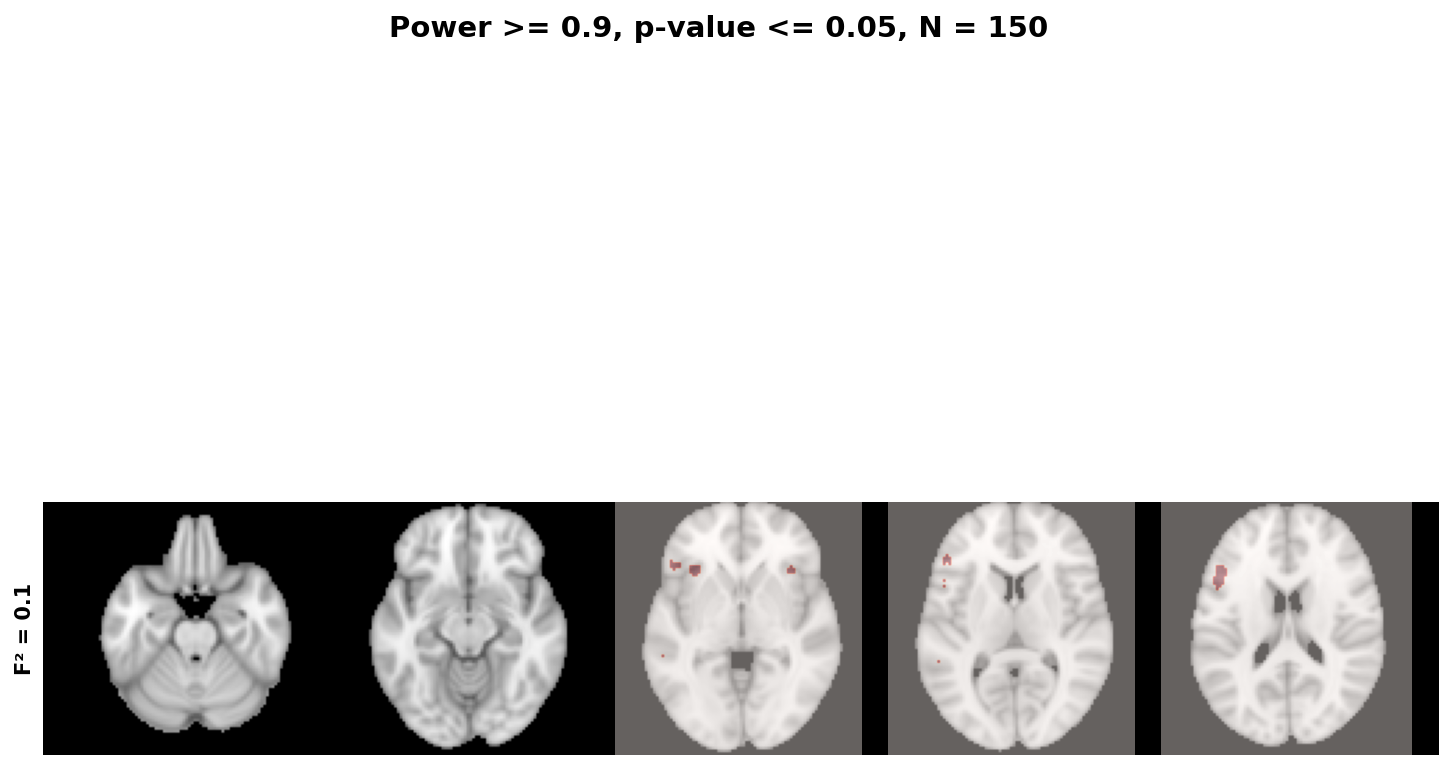

In [27]:
# Define the activation files
activation_files = [
    'images/PowerContrast_N150_p05_Power90_f201.nii.gz'
]

# Load the anatomical image
img = nib.load('anatomical.nii.gz')
data = img.get_fdata()

# Define slices to extract
slices_indices = [24, 30, 35, 40, 45]

# Set up the figure
fig, axes = plt.subplots(len(activation_files), len(slices_indices), figsize=(12, 9), dpi=150)

# Loop through activation files
for row, activation_file in enumerate(activation_files):
    # Load activation data
    activation = nib.load(activation_file)
    activation_data = activation.get_fdata()
    
    # Extract metadata from filename
    match = re.search(r'images/PowerContrast_N(\d+)_p(\d+)_Power(\d+)_f2(\d+)', activation_file)
    if match:
        f_value = float(match.group(4)) / 10
        n_value = match.group(1)
        p_value = float(match.group(2)) / 100
        power_value = float(match.group(3)) / 100
        title_text = f"Power >= {power_value}, p-value <= {p_value}, N = {n_value}"
    else:
        f_value = None
    
    # Loop through slices
    for col, slice_idx in enumerate(slices_indices):
        slice_img = data[:, :, slice_idx]
        activation_img = activation_data[:, :, slice_idx]
        
        # Rotate images by 90 degrees
        rotated_slice = np.flip(rotate(slice_img, 90, reshape=False, mode='constant', cval=0), axis=1)
        rotated_activation = np.flip(rotate(activation_img, 90, reshape=False, mode='constant', cval=0), axis=1)

        
        ax = axes[row, col] if len(activation_files) > 1 else axes[col]
        ax.imshow(rotated_slice, cmap='gray')
        ax.imshow(np.ma.masked_where(rotated_activation == 0, rotated_activation), cmap='Reds', alpha=0.4)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_frame_on(False)
        
        # Set y-axis titles
        if col == 0 and f_value is not None:
            ax.set_ylabel(f"F² = {f_value}", fontsize=10, fontweight='bold')

fig.suptitle(title_text, fontsize=14, fontweight='bold', y=0.95)
plt.subplots_adjust(wspace=-0.1, hspace=0.1)
plt.show()


# Activation Maps - P-Val

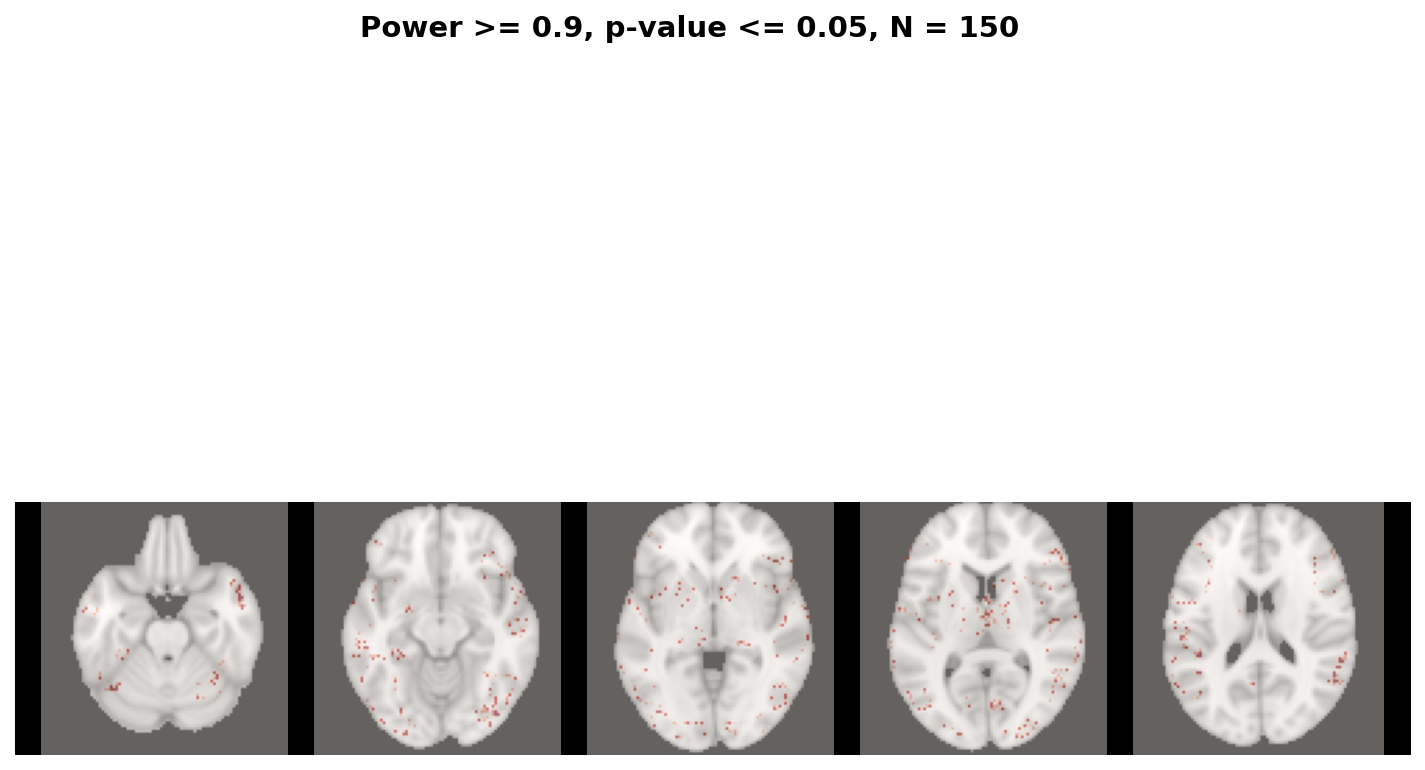

In [28]:
# Define the activation files
activation_files = [
    'images/PValContrast_N150_p05_Power90_f201.nii.gz'
]

# Load the anatomical image
img = nib.load('anatomical.nii.gz')
data = img.get_fdata()

# Define slices to extract
slices_indices = [24, 30, 35, 40, 45]

# Set up the figure
fig, axes = plt.subplots(len(activation_files), len(slices_indices), figsize=(12, 9), dpi=150)

# Loop through activation files
for row, activation_file in enumerate(activation_files):
    # Load activation data
    activation = nib.load(activation_file)
    activation_data = activation.get_fdata()
    
    # Extract metadata from filename
    match = re.search(r'images/PowerContrast_N(\d+)_p(\d+)_Power(\d+)_f2(\d+)', activation_file)
    if match:
        f_value = float(match.group(4)) / 10
        n_value = match.group(1)
        p_value = float(match.group(2)) / 100
        power_value = float(match.group(3)) / 100
        title_text = f"Power >= {power_value}, p-value <= {p_value}, N = {n_value}"
    else:
        f_value = None
    
    # Loop through slices
    for col, slice_idx in enumerate(slices_indices):
        slice_img = data[:, :, slice_idx]
        activation_img = activation_data[:, :, slice_idx]
        
        # Rotate images by 90 degrees
        rotated_slice = np.flip(rotate(slice_img, 90, reshape=False, mode='constant', cval=0), axis=1)
        rotated_activation = np.flip(rotate(activation_img, 90, reshape=False, mode='constant', cval=0), axis=1)

        
        ax = axes[row, col] if len(activation_files) > 1 else axes[col]
        ax.imshow(rotated_slice, cmap='gray')
        ax.imshow(np.ma.masked_where(rotated_activation == 0, rotated_activation), cmap='Reds', alpha=0.4)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_frame_on(False)
        
        # Set y-axis titles
        if col == 0 and f_value is not None:
            ax.set_ylabel(f"F² = {f_value}", fontsize=10, fontweight='bold')

fig.suptitle(title_text, fontsize=14, fontweight='bold', y=0.95)
plt.subplots_adjust(wspace=-0.1, hspace=0.1)
plt.show()


# Activation Maps - Second Generation P-Val

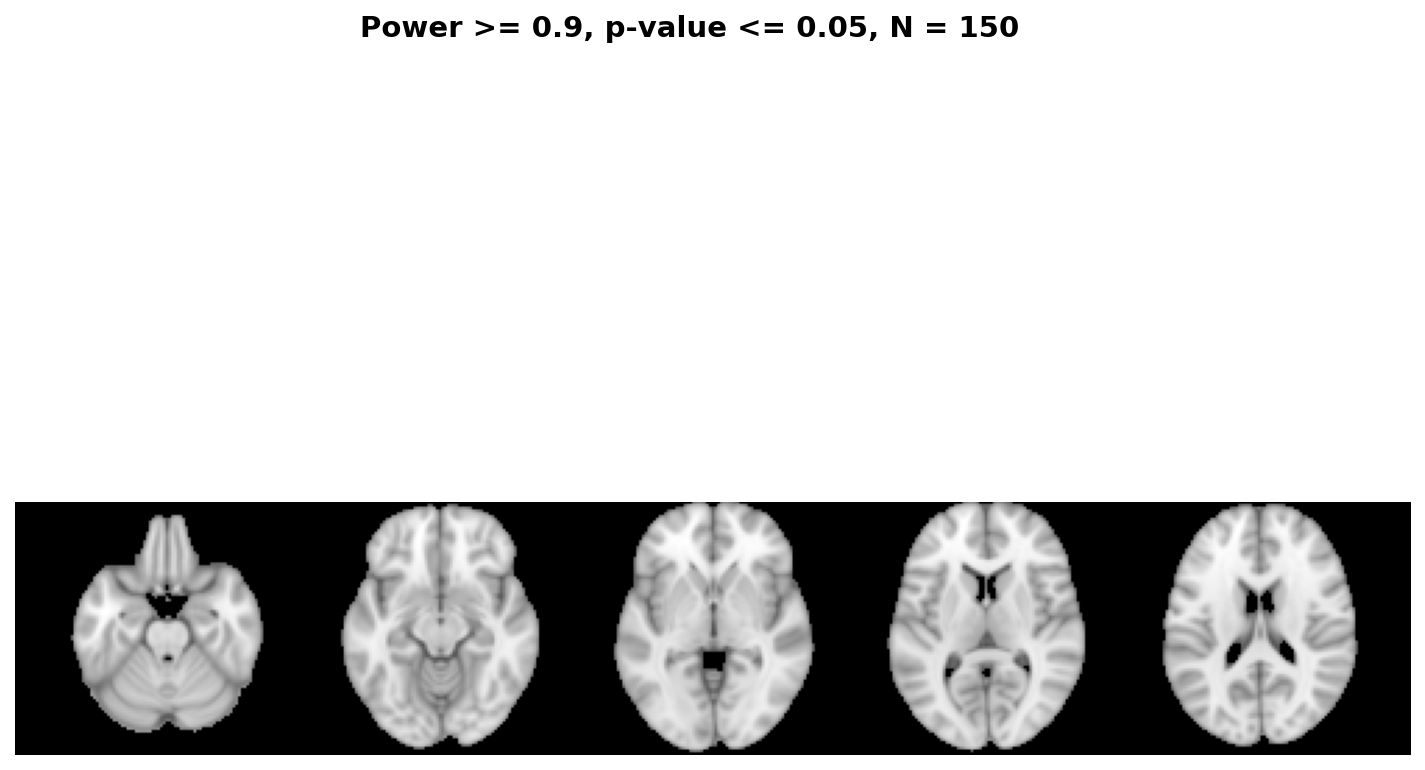

In [29]:
# Define the activation files
activation_files = [
    'images/SecGenPValContrast_N150_p05_Power90_f201.nii.gz'
]

# Load the anatomical image
img = nib.load('anatomical.nii.gz')
data = img.get_fdata()

# Define slices to extract
slices_indices = [24, 30, 35, 40, 45]

# Set up the figure
fig, axes = plt.subplots(len(activation_files), len(slices_indices), figsize=(12, 9), dpi=150)

# Loop through activation files
for row, activation_file in enumerate(activation_files):
    # Load activation data
    activation = nib.load(activation_file)
    activation_data = activation.get_fdata()
    
    # Extract metadata from filename
    match = re.search(r'images/PowerContrast_N(\d+)_p(\d+)_Power(\d+)_f2(\d+)', activation_file)
    if match:
        f_value = float(match.group(4)) / 10
        n_value = match.group(1)
        p_value = float(match.group(2)) / 100
        power_value = float(match.group(3)) / 100
        title_text = f"Power >= {power_value}, p-value <= {p_value}, N = {n_value}"
    else:
        f_value = None
    
    # Loop through slices
    for col, slice_idx in enumerate(slices_indices):
        slice_img = data[:, :, slice_idx]
        activation_img = activation_data[:, :, slice_idx]
        
        # Rotate images by 90 degrees
        rotated_slice = np.flip(rotate(slice_img, 90, reshape=False, mode='constant', cval=0), axis=1)
        rotated_activation = np.flip(rotate(activation_img, 90, reshape=False, mode='constant', cval=0), axis=1)

        
        ax = axes[row, col] if len(activation_files) > 1 else axes[col]
        ax.imshow(rotated_slice, cmap='gray')
        ax.imshow(np.ma.masked_where(rotated_activation == 0, rotated_activation), cmap='Reds', alpha=0.4)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_frame_on(False)
        
        # Set y-axis titles
        if col == 0 and f_value is not None:
            ax.set_ylabel(f"F² = {f_value}", fontsize=10, fontweight='bold')

fig.suptitle(title_text, fontsize=14, fontweight='bold', y=0.95)
plt.subplots_adjust(wspace=-0.1, hspace=0.1)
plt.show()


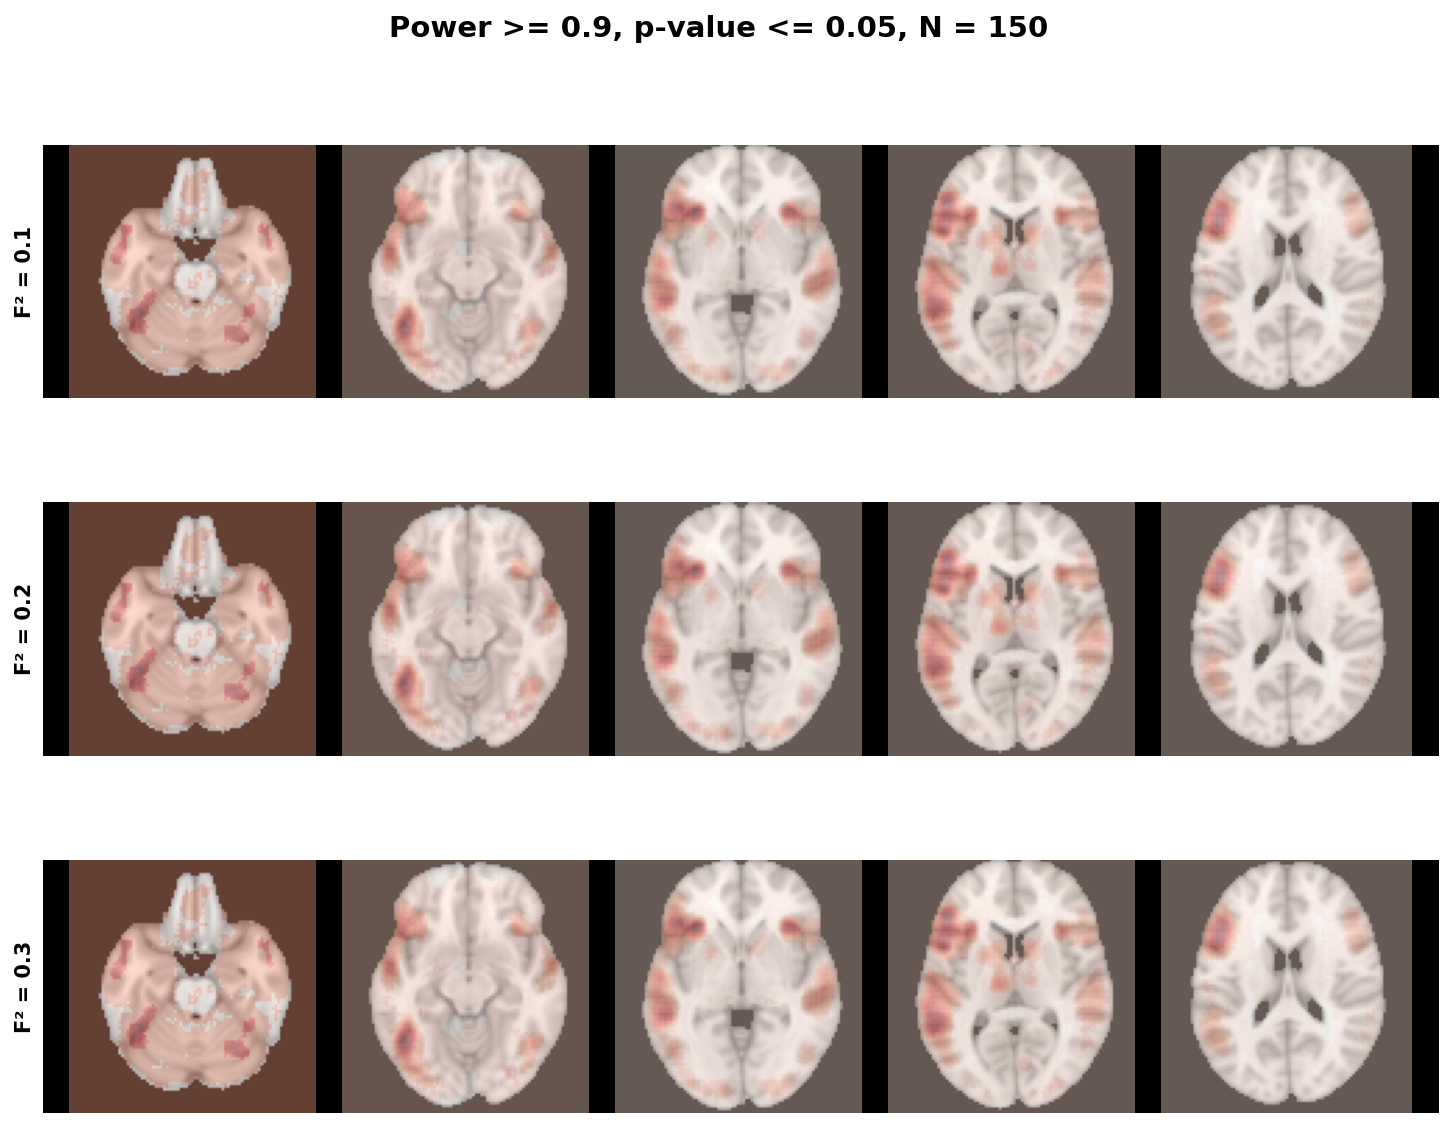

In [105]:
# Define the activation files
activation_files = [
    'images/Contrast1_PVal_N150_Threshold5_f201.nii.gz',
    'images/Contrast1_PVal_N150_Threshold5_f202.nii.gz',
    'images/Contrast1_PVal_N150_Threshold5_f203.nii.gz'
]

# Load the anatomical image
img = nib.load('anatomical.nii.gz')
data = img.get_fdata()

# Define slices to extract
slices_indices = [24, 30, 35, 40, 45]

# Set up the figure
fig, axes = plt.subplots(len(activation_files), len(slices_indices), figsize=(12, 9), dpi=150)

# Loop through activation files
for row, activation_file in enumerate(activation_files):
    # Load activation data
    activation = nib.load(activation_file)
    activation_data = activation.get_fdata()
    
    # Extract metadata from filename
    match = re.search(r'images/Contrast1_PVal_N(\d+)_Threshold(\d+)_f2(\d+)', activation_file)
    if match:
        f_value = float(match.group(3)) / 10
        n_value = match.group(1)
        p_value = float(match.group(2)) / 100
        title_text = f"Power >= {power_value}, p-value <= {p_value}, N = {n_value}"
    else:
        f_value = None
    
    # Loop through slices
    for col, slice_idx in enumerate(slices_indices):
        slice_img = data[:, :, slice_idx]
        activation_img = activation_data[:, :, slice_idx]
        
        # Rotate images by 90 degrees
        rotated_slice = np.flip(rotate(slice_img, 90, reshape=False, mode='constant', cval=0), axis=1)
        rotated_activation = np.flip(rotate(activation_img, 90, reshape=False, mode='constant', cval=0), axis=1)

        
        ax = axes[row, col] if len(activation_files) > 1 else axes[col]
        ax.imshow(rotated_slice, cmap='gray')
        ax.imshow(np.ma.masked_where(rotated_activation == 0, rotated_activation), cmap='Reds', alpha=0.4)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_frame_on(False)
        
        # Set y-axis titles
        if col == 0 and f_value is not None:
            ax.set_ylabel(f"F² = {f_value}", fontsize=10, fontweight='bold')

fig.suptitle(title_text, fontsize=14, fontweight='bold', y=0.95)
plt.subplots_adjust(wspace=-0.1, hspace=0.1)
plt.show()


# Second Generation P-Value

In [ ]:
def calculate_second_gen_p_value(observed_effect, null_hypothesis, effect_interval, n):
    """
    Calculate second-generation p-value for neuroimaging data
    
    Parameters:
        observed_effect (float): Estimated effect size from neuroimaging analysis
        null_hypothesis (float): Point null hypothesis value #### this should be the mean of the population (which for fmri is 0?)
        effect_interval (float): Interval of practically equivalent effects
    
    Returns:
        tuple: (delta_p, interpretation)
    """
    
    # Hypothetical standard error (would be calculated from the sample size)
    std_error = 1 / np.sqrt(n)
    #print(std_error)
    
    #CI of each voxel
    # Lower and upper bounds of confidence interval
    ci_lower = observed_effect - (observed_effect * std_error) #####observed_effect is the z_score???
    #print(ci_lower)
    ci_upper = observed_effect + (observed_effect * std_error)
    #print(ci_upper)
    
    #H0 of overall study
    # Lower and upper bounds of effect interval
    interval_lower = null_hypothesis - effect_interval
    #print(interval_lower)
    interval_upper = null_hypothesis + effect_interval
    #print(interval_upper)
    
    # Calculate second-generation p-value
    if ci_upper <= interval_upper and ci_lower >= interval_lower: #CI entirely contained in the indifference zone (interval)
        # Conclusive evidence against null
        delta_p = 1.0
        interpretation = 'The data supports the null hypothesis - not scientifically or clinically meaningful'
    elif ci_upper < interval_lower or ci_lower > interval_upper: #absolutely no overlap of CI with the indifference zone 
        # Confidence interval completely covers equivalence interval
        delta_p = 0.0
        interpretation = 'The data supports an alternative hypothesis that is scientifically OR clinically meaningful'
    elif (ci_upper - ci_lower) > (2*(interval_upper-interval_lower)): 
        # Confidence interval more than twice the length of the null interval (p.4 and top p.6)
        delta_p = 0.5
        interpretation = 'Data is strictly inconclusive'
    else: 
        # Confidence interval less than twice the length of the null interval (p.4)
        # Partial overlap (either above or below null interval) - ### is there a situation in which it could be both?
        overlap_lower = max(ci_lower, interval_lower)
        overlap_upper = min(ci_upper, interval_upper)
        
        # Calculate proportion of overlap
        delta_p = (overlap_upper - overlap_lower) / (ci_upper - ci_lower)
        interpretation = 'Partial evidence, some consistency with null' #overlap fraction
         
    return p_value


In [100]:
# Load fMRI images
MNIAtlas = load_nii('anatomical.nii.gz')
Contrast = load_nii('language_uniformity-test_z_FDR_0.01.nii.gz')
#Contrast = load_nii('language_association_test_z_FDR_0.01.nii.gz')

# Extract image data
Contrast_img = Contrast.get_fdata()

#null_hypothesis = 0
null_hypothesis = Contrast_img.mean()

effect_interval = 0.1

for a in f2:

    # Get image dimensions correctly
    XDIM, YDIM, ZDIM = Contrast_img.shape
    PowerImage1 = np.zeros((XDIM, YDIM, ZDIM))

    # P-Val analysis
    for n in Ns:
        for i in range(XDIM):
            for j in range(YDIM):
                for k in range(ZDIM):
                    if Contrast_img[i, j, k] > 0:
                        p_value = calculate_second_gen_p_value(Contrast_img[i, j, k], null_hypothesis, effect_interval, n)
                        if p_value < 0.5:
                            PowerImage1[i, j, k] = p_value #adjusts 3d matrix on values to only include p-values below alpha (overwrites default zeros)


        #Scale after converting z to p
        #ContrastImage1 = np.max(PowerImage1) # Compute max contrast
        #PowerImage = (a / ContrastImage1) * Contrast_img # Scale contrast images

        # Format filename correctly
        f2value = str(a).replace('0.', '0')
        filename = f'images/Contrast1_2nd_Gen_PVal_N{n}_Threshold{int(p * 100)}_f2{f2value}.nii.gz'
        print(filename)
        print(PowerImage1.flatten().min())
        print(PowerImage1.flatten().max())
        print(PowerImage1.flatten().mean())

        # Save power image as a NIfTI file
        PowerImage_nii = nib.Nifti1Image(PowerImage1, Contrast.affine, Contrast.header)
        nib.save(PowerImage_nii, filename)


images/Contrast1_2nd_Gen_PVal_N150_Threshold5_f201.nii.gz
0.0
0.0
0.0
images/Contrast1_2nd_Gen_PVal_N150_Threshold5_f202.nii.gz
0.0
0.0
0.0
images/Contrast1_2nd_Gen_PVal_N150_Threshold5_f203.nii.gz
0.0
0.0
0.0


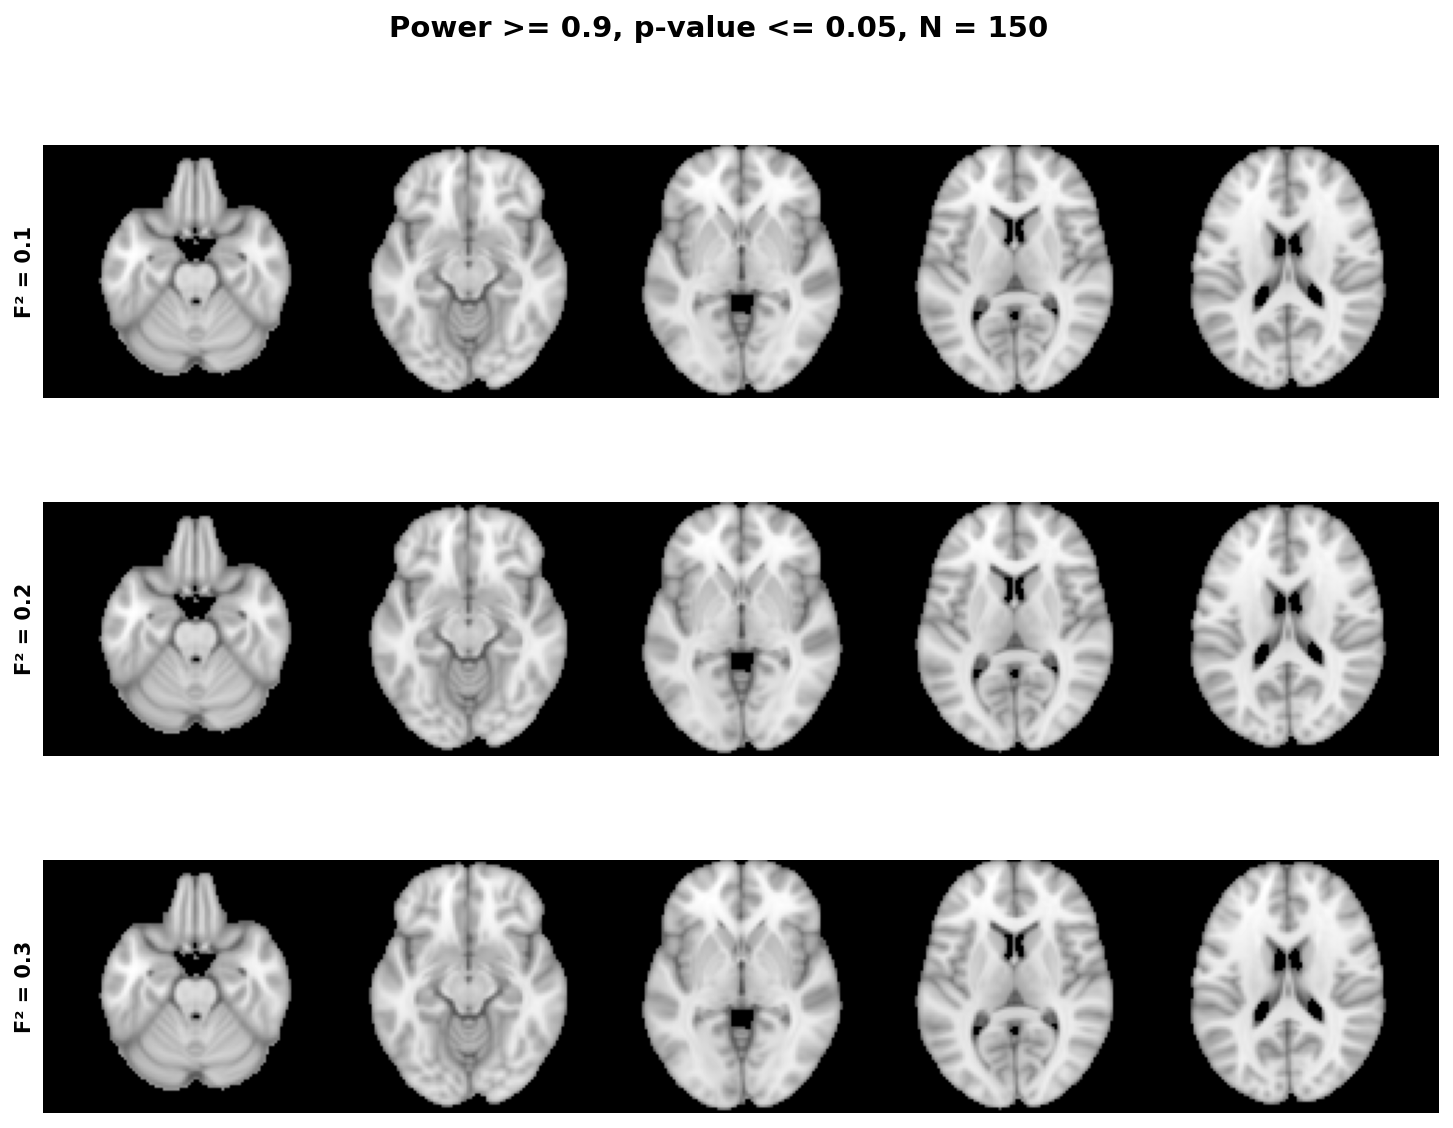

In [101]:
# Define the activation files
activation_files = [
    'images/Contrast1_2nd_Gen_PVal_N150_Threshold5_f201.nii.gz',
    'images/Contrast1_2nd_Gen_PVal_N150_Threshold5_f202.nii.gz',
    'images/Contrast1_2nd_Gen_PVal_N150_Threshold5_f203.nii.gz'
]

# Load the anatomical image
img = nib.load('anatomical.nii.gz')
data = img.get_fdata()

# Define slices to extract
slices_indices = [24, 30, 35, 40, 45]

# Set up the figure
fig, axes = plt.subplots(len(activation_files), len(slices_indices), figsize=(12, 9), dpi=150)

# Loop through activation files
for row, activation_file in enumerate(activation_files):
    # Load activation data
    activation = nib.load(activation_file)
    activation_data = activation.get_fdata()
    
    # Extract metadata from filename
    match = re.search(r'images/Contrast1_2nd_Gen_PVal_N(\d+)_Threshold(\d+)_f2(\d+)', activation_file)
    if match:
        f_value = float(match.group(3)) / 10
        n_value = match.group(1)
        p_value = float(match.group(2)) / 100
        title_text = f"Power >= {power_value}, p-value <= {p_value}, N = {n_value}"
    else:
        f_value = None
    
    # Loop through slices
    for col, slice_idx in enumerate(slices_indices):
        slice_img = data[:, :, slice_idx]
        activation_img = activation_data[:, :, slice_idx]
        
        # Rotate images by 90 degrees
        rotated_slice = np.flip(rotate(slice_img, 90, reshape=False, mode='constant', cval=0), axis=1)
        rotated_activation = np.flip(rotate(activation_img, 90, reshape=False, mode='constant', cval=0), axis=1)

        
        ax = axes[row, col] if len(activation_files) > 1 else axes[col]
        ax.imshow(rotated_slice, cmap='gray')
        ax.imshow(np.ma.masked_where(rotated_activation == 0, rotated_activation), cmap='Reds', alpha=0.4)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_frame_on(False)
        
        # Set y-axis titles
        if col == 0 and f_value is not None:
            ax.set_ylabel(f"F² = {f_value}", fontsize=10, fontweight='bold')

fig.suptitle(title_text, fontsize=14, fontweight='bold', y=0.95)
plt.subplots_adjust(wspace=-0.1, hspace=0.1)
plt.show()


In [89]:
alpha =  0.05

def calculate_second_gen_p_value(observed_effect, null_hypothesis, effect_interval, n):
    """
    Calculate second-generation p-value for neuroimaging data
    
    Parameters:
        observed_effect (float): Estimated effect size from neuroimaging analysis
        null_hypothesis (float): Point null hypothesis value #### this should be the mean of the population (which for fmri is 0?)
        effect_interval (float): Interval of practically equivalent effects
    
    Returns:
        tuple: (delta_p, interpretation)
    """
    
    # Hypothetical standard error (would be calculated from actual data)
    std_error = 1 / np.sqrt(n)
    #print(std_error)
    
    #CI of each voxel
    # Lower and upper bounds of confidence interval
    ci_lower = observed_effect - (observed_effect * std_error)
    #print(ci_lower)
    ci_upper = observed_effect + (observed_effect * std_error)
    #print(ci_upper)
    
    #H0 of overall study
    # Lower and upper bounds of effect interval
    interval_lower = null_hypothesis - effect_interval
    #print(interval_lower)
    interval_upper = null_hypothesis + effect_interval
    #print(interval_upper)
    
    # Calculate second-generation p-value
    if ci_upper <= interval_upper and ci_lower >= interval_lower: #CI entirely contained in the indifference zone (interval)
        # Conclusive evidence against null
        delta_p = 1.0
        interpretation = 'The data supports the null hypothesis - not scientifically or clinically meaningful'
    elif ci_upper < interval_lower or ci_lower > interval_upper: #absolutely no overlap of CI with the indifference zone 
        # Confidence interval completely covers equivalence interval
        delta_p = 0.0
        interpretation = 'The data supports an alternative hypothesis that is scientifically OR clinically meaningful'
    elif (ci_upper - ci_lower) > (2*(interval_upper-interval_lower)): 
        # Confidence interval more than twice the length of the null interval (p.4 and top p.6)
        delta_p = 0.5
        interpretation = 'Data is strictly inconclusive'
    else: 
        # Confidence interval less than twice the length of the null interval (p.4)
        # Partial overlap (either above or below null interval) - ### is there a situation in which it could be both?
        overlap_lower = max(ci_lower, interval_lower)
        overlap_upper = min(ci_upper, interval_upper)
        
        # Calculate proportion of overlap
        delta_p = (overlap_upper - overlap_lower) / (ci_upper - ci_lower)
        interpretation = 'Partial evidence, some consistency with null' #overlap fraction
         
    return delta_p


In [92]:
n = 150
effect_interval= 4

# Load fMRI images
MNIAtlas = load_nii('anatomical.nii.gz')
#Contrast1 = load_nii('language_uniformity-test_z_FDR_0.01.nii.gz')
Contrast1 = load_nii('language_association_test_z_FDR_0.01.nii.gz')

# Extract image data
Contrast1_img = Contrast1.get_fdata()
print(Contrast1_img.min())
print(Contrast1_img.max())
print(Contrast1_img.mean())

null_hypothesis = Contrast1_img.mean()


# Get image dimensions correctly
XDIM, YDIM, ZDIM = Contrast1_img.shape
PowerImage1 = np.zeros((XDIM, YDIM, ZDIM))

for i in range(XDIM):
    for j in range(YDIM):
        for k in range(ZDIM):
            if Contrast1_img[i, j, k] > 0:
                delta_p = calculate_second_gen_p_value(Contrast1_img[i, j, k], null_hypothesis, effect_interval, n) # only calculate on non-0 values
                if delta_p < 0.5:
                    PowerImage1[i, j, k] = delta_p #adjusts 3d matrix on values to only include power values that meet threshold (overwrites default zeros)

# Format filename correctly
pvalue = str(alpha).replace('0.', '')
filename = f'images/Contrast1_p{pvalue}_SecondGenP.nii.gz'
print(PowerImage1.flatten().min())
print(PowerImage1.flatten().max())
print(PowerImage1.flatten().mean())

# Save power image as a NIfTI file
PowerImage_nii = nib.Nifti1Image(PowerImage1, Contrast1.affine, Contrast1.header) ###### something isn't translating correctly here
nib.save(PowerImage_nii, filename)



-4.830081204916775
15.920949754104074
0.0916280276847267
0.0
0.498200587841875
0.00041006469156157566


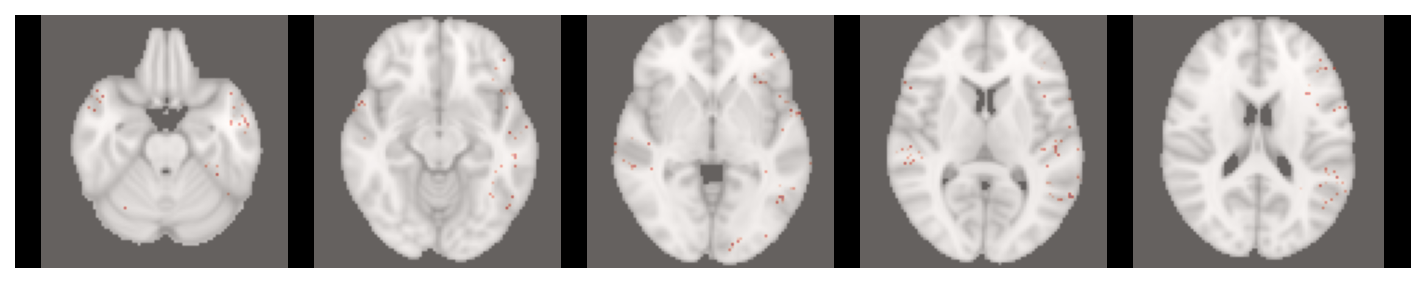

In [93]:
from scipy.ndimage import rotate
import nibabel as nib
import numpy as np
import re
import matplotlib.pyplot as plt

# Define the activation files
activation_files = [
    'images/Contrast1_p05_SecondGenP.nii.gz'
]

# Load the anatomical image
img = nib.load('anatomical.nii.gz')
data = img.get_fdata()

# Define slices to extract
slices_indices = [24, 30, 35, 40, 45]

# Set up the figure
fig, axes = plt.subplots(len(activation_files), len(slices_indices), figsize=(12, 9), dpi=150)

# Loop through activation files
for row, activation_file in enumerate(activation_files):
    # Load activation data
    activation = nib.load(activation_file)
    activation_data = PowerImage1#activation.get_fdata()
    
    # Loop through slices
    for col, slice_idx in enumerate(slices_indices):
        slice_img = data[:, :, slice_idx]
        activation_img = activation_data[:, :, slice_idx]
        
        # Rotate images by 90 degrees
        rotated_slice = rotate(slice_img, 90, reshape=False, mode='constant', cval=0)
        rotated_activation = rotate(activation_img, 90, reshape=False, mode='constant', cval=0)
        
        ax = axes[row, col] if len(activation_files) > 1 else axes[col]
        ax.imshow(rotated_slice, cmap='gray')
        ax.imshow(np.ma.masked_where(rotated_activation == 0, rotated_activation), cmap='Reds', alpha=0.4)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_frame_on(False)

plt.subplots_adjust(wspace=-0.1, hspace=0.1)
plt.show()


# Ternary Plots

In [ ]:
alpha =  0.05
cohens_f2 = 0.2
df1 = 1
df2 = #have to calculate sample size from file
pop_mean = #have to calculate mean from file

power, stat_p_val = power_calcs2(df1, df2, cohens_f2, alpha) #edit to output p-val instead of cohens_f2
second_gen_pval = calculate_second_gen_p_value(observed_effect, null_hypothesis, effect_interval, alpha)

In [ ]:
import pandas as pd
    
stat_pval = []
power = []
sec_gen_pval = []
df = pd.DataFrame(list(zip(stat_pval, power, sec_gen_pval)), columns=['Statistical_Pval', 'Power', '2nd_Gen_Pval'])
df.head()

In [ ]:
import plotly.express as px

fig = px.scatter_ternary(df, a="Statistical_Pval", b="Power", c="2nd_Gen_Pval")
fig.show()